# Cloud-native access for EFI-curated data sources

## in Python


This vignette illustrates how we can efficiently access large data resources from the EFI cloud storage. This approach is zero-copy, i.e. avoids the need to ever download data.  This approach is fast, scalable, requires minimal RAM, and particularly effective on machines with high network bandwidth. This vignette also emphasizes modern and user-friendly syntax from widely adopted and standard libraries which are supported in many languages. This syntax should translate relatively simply between python, R, and most other modern data science languages (rust, julia, javascript, etc, through standard interfaces such as Apache Arrow).



We will use the python module `pyarrow` to handle the underlying remote data connections, and the [`polars`](https://www.pola.rs/) module for a fast, modern data frame interface.

In [8]:
import  polars as pl
import pyarrow.dataset as ds
from pyarrow import fs

## NOAA Forecasts at NEON sites

NOAA Global Ensemble Forecasting System, [GEFS]() provides 31 ensemble member forecasts on a 3-6hr intervals over a 35-day horizon worldwide.
Accessing these directly from NOAA snapshots (in `grib2` format) and downscaling to desired locations is computationally intensive, so EFI
pre-compiles snapshots of these at each of the NEON sites in an efficient parquet format.

Several different compilations of the NOAA data are available.  In particular, using historical forecasts at a site in lieu of actual observations
as 'drivers' or predictor variables when building forecasts can be desirable, since future predictions necessarily must use forecasts and 
observed values may differ systematically.  EFI's stage3 product makes it easy to access the 0-hour 'forecast' for the desired variable at the NEON site.


To get started, we establish a connection to EFI's S3-based object store using `pyarrow.filesystem`.  Because read-only data access is public, we do not need any access credentials and can connect annonymously.  


In [11]:
s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)

To access the dataset of interest, we have to know its path.  Eventually all paths will be discoverable by using a STAC based catalog search and web index, but for now, we use the specific path for the stage1 NOAA GEFS at cycle 0 on a a given date.  we register this dataset with `pyarrow` dataset and scan it with polars for easy queires.  

In [12]:

date = "2023-03-18"
path = f"neon4cast-drivers/noaa/gefs-v12/stage1/0/{date}"
dataset = ds.dataset(path, filesystem=s3)
today_noaa = pl.scan_pyarrow_dataset(dataset) 


Note that EFI's stage1 NOAA data represents direct extraction from the NOAA GEFS grib product at NOAA sites for 7 commonly referenced variables, and follows the EFI forecasting standard for column names.

```
ds.select("variable").unique().collect()
```

- PRES: Atmospheric Pressure 
- TMP: Air temperature
- RH: Relative humidity
- UGRD: U-component of wind speed (windspeed * cosine(theta) where theta is angle from due-east)
- VGRD: V-component of wind speed (windspeed * sine(theta) where theta is angle from due-east)
- APCP: accumulated percipatation in current period. *Note - 'current period' shifts from a 3hr interval to 6 hour interval at a horizon of 240 hours
- DSWRF: Direct shortware radiation flux
- DLWRF: Direct longwave radiation flux


All values correspond to forecast made for a height of 2 meters above ground.  Let's query temperature values at a given site for illustration:

In [15]:
 df = (today_noaa
  .filter(pl.col("site_id") == "BART")
  .filter(pl.col("variable") == "TMP")
  .collect()
 )

We use the powerful [polars syntax](https://pola-rs.github.io/polars-book/user-guide/quickstart/intro.html) to make some basic queries.  Note the use of `collect()` at the end of the query, which triggers the lazy execution, running the filters and bringing only the resulting data into memory. We can quickly visualize the resulting ensemble forecast:

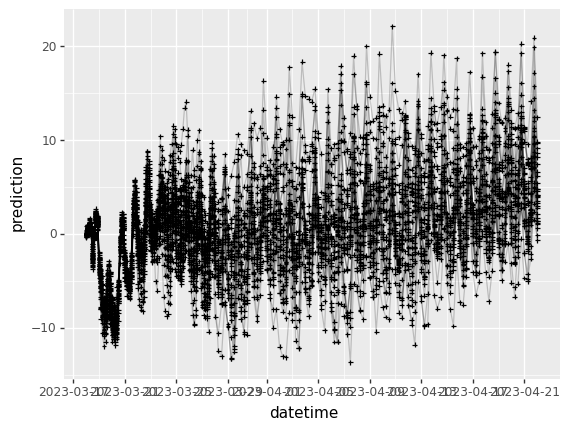

<ggplot: (8769922946775)>

In [24]:
import plotnine as gg

(
    gg.ggplot(df, gg.aes("datetime", "prediction", group="parameter"))
    + gg.geom_line(alpha=0.2) + gg.geom_point(shape="+")
)


# NEON Data

We use a very similar strategy to access NEON data. As before, the main trick at the moment is knowing the right path to use, especially given NEON's somewhat esoteric naming conventions.  The 30min-average triple-aspirated air temperature measurements (TAAT) table can be accessed as follows:


In [42]:
path = "neon4cast-targets/neon/TAAT_30min-basic-DP1.00003.001"
temp = ds.dataset(path, filesystem=s3)
#neon_temp = pl.scan_pyarrow_dataset(temp) 

In [43]:
## ick we have some datatype compatibility issue to fix, meanswhile, use duckdb access via Ibis
import ibis
duckdb = ibis.duckdb.connect()
neon_temp = duckdb.register(temp)

#neon_temp

In [52]:
ibis.timestamp("2023-02-01", timezone="UTC")


datetime.datetime(2023, 2, 1, 0, 0, tzinfo=<UTC>)

In [56]:
df = (neon_temp
 .filter(neon_temp.siteID == "BART")
 #.filter(neon_temp.startDateTime > ibis.timestamp("2023-02-01", timezone=None))
 #.filter(neon_temp.startDateTime < ibis.timestamp("2023-02-03", timezone=None))
 .limit(10)
).to_pandas()



FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [ ]:

(
    gg.ggplot(df, gg.aes("datetime", "prediction", group="parameter"))
    + gg.geom_line(alpha=0.2) + gg.geom_point(shape="+")
)

# EFI forecasts and scores

Another set of EFI data products are the scored forecasts by theme.  This includes summary statistics of uncertainty of each forecast.  It is similarly possible to a


In [57]:
path = "neon4cast-scores/parquet/aquatics"
py = ds.dataset(path, filesystem=s3)
scores = pl.scan_pyarrow_dataset(py) 

In [ ]:
from datetime import datetime

df = (scores
      .filter(pl.col("site_id")=="BART")
      .filter(pl.col("variable")=="temperature")
      .filter(pl.col("reference_datetime")==datetime(2023, 3, 18))
      .collect()
             )
df

In [ ]:
(
    gg.ggplot(df, gg.aes("datetime", "mean"))
    + gg.geom_line(alpha=0.2) + gg.geom_point(shape="+")
)